## Getting the Dataset

In [0]:
from urllib.request import urlretrieve
import os
from zipfile import ZipFile

def download(url, file):
    if not os.path.isfile(file):
        print("Download file... " + file + " ...")
        urlretrieve(url,file)
        print("File downloaded")

download('https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip','data.zip')
print("All the files are downloaded")

All the files are downloaded


In [0]:
!unzip data.zip -d data

In [0]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('data/dogImages/train')
valid_files, valid_targets = load_dataset('data/dogImages/valid')
test_files, test_targets = load_dataset('data/dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("data/dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# %matplotlib inline

# Fastai Library
import fastai
from fastai.vision import *
from fastai.vision.models import *
import torch

# Others
from pathlib import Path
import glob

In [0]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [0]:
path_to_folder = 'data/dogImages/'

In [0]:
tfms = get_transforms(do_flip=True, flip_vert=False, max_rotate=45)

In [0]:
data = ImageDataBunch.from_folder(path_to_folder, size= 224, bs = 32, ds_tfms = tfms)
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (6680 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
041.Bullmastiff,041.Bullmastiff,041.Bullmastiff,041.Bullmastiff,041.Bullmastiff
Path: data/dogImages;

Valid: LabelList (835 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
041.Bullmastiff,041.Bullmastiff,041.Bullmastiff,041.Bullmastiff,041.Bullmastiff
Path: data/dogImages;

Test: None

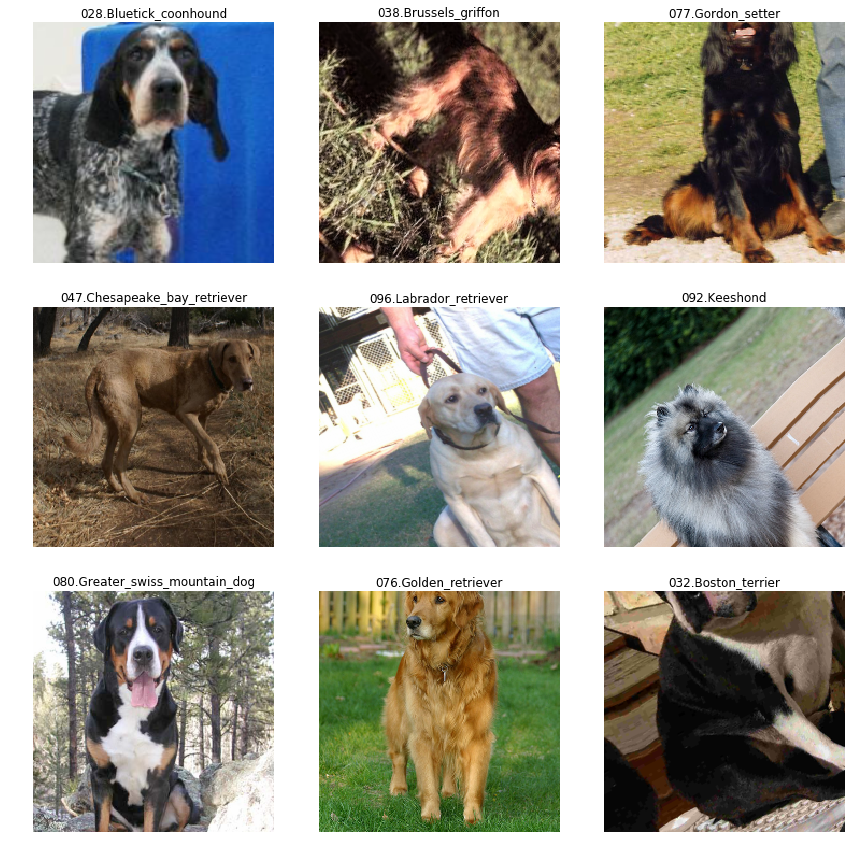

In [0]:
# show sample of images.
data.show_batch(rows=3, figsize=(12,12))

# Model Preparation

In [0]:
from sklearn.metrics import f1_score

# Making Function to use it in metrics for the CNN.
def f1_macro_score(y_pred, y_true, tens=True):
    score = f1_score(y_true, np.argmax(y_pred, axis = 1), average = 'macro')
    if tens:
        score= tensor(score)
    else:
        score= score
    return score

# Function to calculate the F1-Score for validation data using Confusion Matrix.
def f1_from_cm(cm):
    TP = np.diag(cm)
    FP = np.sum(cm, axis=0) - TP
    FN = np.sum(cm, axis=1) - TP
    num_classes = 25
    TN = []
    for i in range(num_classes):
      temp = np.delete(cm, i, 0)
      temp = np.delete(temp, i, 1)
      TN.append(sum(sum(temp)))
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    F1 = 2 * (precision.mean() * recall.mean()) / (precision.mean() + recall.mean())
    return F1

In [0]:
def performane_indiators(model):
    # Plotting some curves to see the performance.
    model.recorder.plot_losses()
    model.recorder.plot_metrics()
    model.recorder.plot()
    
    # Print confusion matrix, F1 score and top losses.
    result = ClassificationInterpretation.from_learner(model)
    result.plot_top_losses(9, figsize=(15,15) , heatmap = False)
    print("F1-Score for validation is {}".format(f1_from_cm(result.confusion_matrix())))

In [0]:
# Making The CNN Model Using Our Images And Densenet161 Architeture.
model = cnn_learner(data, resnet101, metrics = [accuracy])

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/checkpoints/resnet101-5d3b4d8f.pth
100%|██████████| 178728960/178728960 [00:08<00:00, 20494375.42it/s]


# Model Training

In [0]:
model.fit_one_cycle(10)

epoch,train_loss,valid_loss,accuracy,time
0,2.201506,0.953107,0.765269,02:54
1,0.988042,0.497734,0.853892,02:53
2,0.762299,0.403891,0.864671,02:51
3,0.697996,0.405682,0.858683,02:53
4,0.603302,0.377901,0.880240,02:53
5,0.447462,0.295439,0.902994,02:54
6,0.345312,0.319988,0.898204,02:54
7,0.278657,0.260185,0.908982,02:53
8,0.247998,0.249925,0.913772,02:55
9,0.221207,0.255959,0.919760,02:53


In [0]:
model.unfreeze()
model.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 2.75E-06
Min loss divided by 10: 6.31E-08


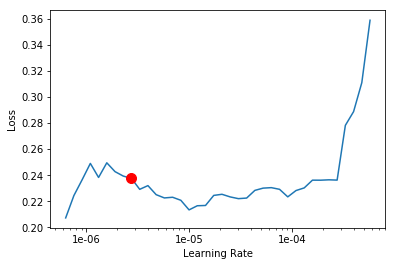

In [0]:
model.recorder.plot(suggestion = True)

In [0]:
model.fit_one_cycle(10, max_lr = slice(1e-6, 1e-5))

epoch,train_loss,valid_loss,accuracy,time
0,0.195516,0.249998,0.922156,03:04
1,0.208669,0.249410,0.918563,03:03
2,0.213476,0.257641,0.914970,03:04
3,0.194102,0.246407,0.925749,03:05
4,0.195273,0.244164,0.923353,03:04
5,0.184521,0.245803,0.928144,03:02
6,0.186564,0.244265,0.922156,03:03
7,0.164575,0.239331,0.925749,03:03
8,0.169370,0.245023,0.920958,03:05
9,0.163936,0.250232,0.922156,03:03


In [0]:
performane_indiators(model)